Q3: Implementation of Neural Networks from Scratch Using NumPy and Comparison with Sklearn (20 marks):
  
    1. Load and preprocess the MNIST Digits Dataset. (3 marks)
    2. Implement a neural network with one input layer, one hidden layer, and one output layer using NumPy. (5 marks)
    3. Train the neural network with various hyperparameters (e.g., learning rate, number of hidden nodes). (3 marks)
    4. Evaluate the performance of the neural network on the testing set. (2 marks)
    5. Implement the same neural network using sklearn and compare the results with the NumPy implementation. (4 marks)
    6. Plot the training and validation loss/accuracy curves (for both experiments). (3 marks)



In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings,gc,sys, random
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from pprint import pprint
np.random.seed(42)

# 1 Load & Preprocess

1. Load and preprocess the MNIST Digits Dataset. (3 marks)

In [2]:
while True:
    try:
        mnist_784_df = pd.read_csv("mnist_784.csv")
        break
    except FileNotFoundError:
        from sklearn.datasets import fetch_openml

        X, y = fetch_openml('mnist_784', return_X_y=True)
        X["Y"] = y
        X.to_csv("mnist_784.csv",index=False,header=True)
        del X,y
# %%script echo skipping

In [3]:
X = mnist_784_df.drop(columns="Y").values.astype(np.float32) / 255.0

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

Y = mnist_784_df["Y"].values
# result = np.where(targets == 5, 1, 0)

IL_n = mnist_784_df.shape[-1]-1
n_neurons_HL = int(np.sqrt(IL_n-1))

scaler = StandardScaler()
inputs = pd.DataFrame(scaler.fit_transform(inputs), columns=inputs)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.20, random_state=42,
    stratify=Y,shuffle=True)

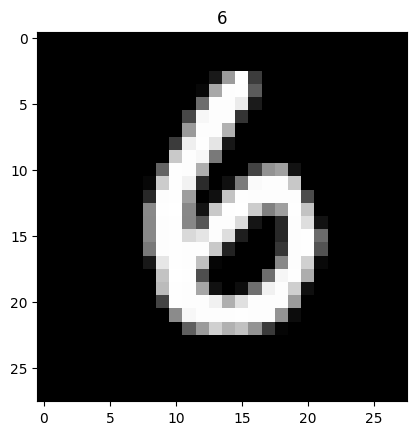

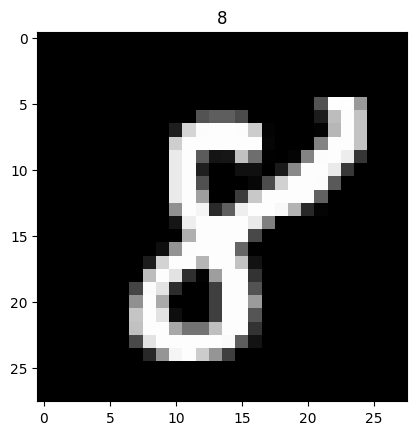

In [5]:
random_index = np.random.choice(len(X_train))
plt.imshow(X_train[random_index].reshape(28, 28), cmap='gray')
plt.title(f'{y_train[random_index]}')
plt.show()
random_index = np.random.choice(len(X_test))
plt.imshow(X_test[random_index].reshape(28, 28), cmap='gray')
plt.title(f'{y_test[random_index]}')
plt.show()

In [6]:
# X_train = X_train.astype(np.float32) / 255.0
# X_test = X_test.astype(np.float32) / 255.0
y_train = np.eye(10)[y_train]  # One-hot encode labels
y_test = np.eye(10)[y_test]  # One-hot encode labels

# 2 Build Neural Network

2. Implement a neural network with one input layer, one hidden layer, and one output layer using NumPy. (5 marks)

In [7]:
def compute_loss(y_pred, y_true, epsilon=1e-10):
       m = y_true.shape[0]
       y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip probabilities
       log_probs = -np.log(y_pred[np.arange(m), y_true.argmax(axis=1)])
       return float(np.sum(log_probs) / m)

In [8]:
class NeuralNetwork:
    # def __init__(self, input_size, hidden_size, output_size):
    def __init__(self, input_size, hidden_size, output_size, batch_size , learning_rate,epochs):
        # He initialization for ReLU
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2./input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2./hidden_size)
        self.b2 = np.zeros(output_size)

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.loss_dict={ "epoch":[],  "train_loss":[], "test_loss":[]}

    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Numerical stability
        return exp_Z / exp_Z.sum(axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        return self.softmax(self.Z2)

    def backprop(self, X, y_true, y_pred):
        m = X.shape[0]

        # Output layer gradient
        dZ2 = y_pred - y_true
        dW2 = (self.A1.T.dot(dZ2)) / m
        db2 = np.sum(dZ2, axis=0) / m

        # Hidden layer gradient
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)  # ReLU derivative
        dW1 = (X.T.dot(dZ1)) / m
        db1 = np.sum(dZ1, axis=0) / m

        # Update parameters
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def fit(self, X_train, y_train, loss = False, X_test = None, y_test = None ):

        X_batches,y_batches = [], []
        count=0
        for i in range(0,X_train.shape[0], self.batch_size):
            X_batches.append(X_train[i:i+self.batch_size])
            y_batches.append(y_train[i:i+self.batch_size])
            count+=1
        for epoch in range(self.epochs):

            # Mini-batch training
            for i in range(count):

                self.backprop(X = X_batches[i],
                              y_true = y_batches[i],
                              y_pred = self.forward(X_batches[i]))

            # Compute epoch loss
            if (epoch+1)%(self.epochs//10) == 0:
                if loss:
                    self.loss_dict["epoch"].append(epoch)
                    y_pred = self.forward(X_train)
                    train_loss = compute_loss(y_pred = y_pred, y_true = y_train)

                    # print(y_pred.shape,"\n",y_pred)
                    # print(y_train.shape,"\n",y_train)
                    # sys.exit()
                    self.loss_dict["train_loss"].append(train_loss)

                    test_loss = compute_loss(y_pred = self.forward(X_test), y_true = y_test)
                    self.loss_dict["test_loss"].append(test_loss)
            # sys.exit()
    def predict(self,X):
        return self.forward(X)

    def score(self,X,y):
        y_pred = self.predict(X)
        predictions = np.argmax(y_pred, axis=1)
        labels = np.argmax(y, axis=1)
        return accuracy_score(labels,predictions)

    def get_params(self, deep=True):
        # """Get parameters for this estimator."""
        return {
            "input_size": self.input_size,
            "hidden_size": self.hidden_size,
            "output_size": self.output_size,
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "epochs": self.epochs
        }

    def set_params(self, **parameters):
        """Set the parameters of this estimator."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# 3 Train Neural Net

3. Train the neural network with various hyperparameters (e.g., learning rate, number of hidden nodes). (3 marks)

In [ ]:
# Initialize network
%%time
nn = NeuralNetwork(input_size=784, output_size=10,
                   # Hyperparameters
                   hidden_size=300,batch_size = 128, learning_rate = 0.1,epochs = 10)
nn.fit(X_train = X_train,y_train = y_train)
# pprint(nn.loss_dict)

In [ ]:
y_pred = nn.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
labels = np.argmax(y_test, axis=1)
print(accuracy_score(labels,predictions))

# 4 Performance testing

4. Evaluate the performance of the neural network on the testing set. (2 marks)

In [ ]:
cm = confusion_matrix(labels, predictions)
# Get unique class labels
unique_labels = np.unique(labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels) # Use unique labels
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=unique_labels.astype(str))) # Use unique labels as target names

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,space_eval
from pprint import pprint
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
def objective(params):

    nn_clf = NeuralNetwork(**params)

    score = cross_val_score(nn_clf, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
input_size = 784
output_size=10
print(int(np.sqrt(input_size+1)))

In [ ]:
input_size = 784
output_size=10
space = {
    'input_size': hp.choice('input_size', [input_size]),
    'output_size': hp.choice('output_size', [output_size]),
    "epochs": hp.choice("epochs",[50]),

    'hidden_size': hp.uniformint("hidden_size", int(np.sqrt(input_size+1)), int((input_size+1)/2)),
    'batch_size': hp.uniformint("batch_size", int(X_train.shape[0]/1000), int(X_train.shape[0]/100)),
    "learning_rate": hp.uniform('learning_rate', 0.001, 0.1),

}


In [ ]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
best_params = space_eval(space=space,hp_assignment=best)
print("Best parameters: ")
pprint(best_params)

In [ ]:
# best_params = {'batch_size': 177,
#  'epochs': 50,
#  'hidden_size': 285,
#  'input_size': 784,
#  'learning_rate': 0.08644110664186987,
#  'output_size': 10}

In [ ]:
best_NN_clf = NeuralNetwork(**best_params)
best_NN_clf.fit(X_train, y_train,loss=True,X_test=X_test,y_test=y_test)

y_pred = best_NN_clf.predict(X_test)
predictions = np.argmax(y_pred, axis=1)
labels = np.argmax(y_test, axis=1)

In [ ]:
accuracy = accuracy_score(labels,predictions)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(labels, predictions)
# Get unique class labels
unique_labels = np.unique(labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels) # Use unique labels
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=unique_labels.astype(str))) # Use unique labels as target names

# 5 sklearn Neural Net

5. Implement the same neural network using sklearn and compare the results with the NumPy implementation. (4 marks)

In [ ]:
from sklearn.neural_network import MLPClassifier

MLPClassifier_loss_dict={ "epoch":[],  "train_loss":[], "test_loss":[]}

epochs = best_params["epochs"]
mlp = MLPClassifier(activation='relu', batch_size = best_params["batch_size"],
                    hidden_layer_sizes=(best_params["hidden_size"]), learning_rate_init=best_params["learning_rate"],learning_rate='constant',
                    max_iter=1,
                    # max_iter=best_params["epochs"],
                    random_state=42,
                    warm_start=True,shuffle=False, early_stopping=False)

for epoch in tqdm(range(best_params["epochs"])):

    mlp.fit(X_train, y_train)


    if (epoch+1)%(epochs//10) == 0:
        MLPClassifier_loss_dict["epoch"].append(epoch)

        train_loss = compute_loss(y_pred = mlp.predict_proba(X_train), y_true = y_train)
        MLPClassifier_loss_dict["train_loss"].append(train_loss)

        test_loss = compute_loss(y_pred = mlp.predict_proba(X_test), y_true = y_test)
        MLPClassifier_loss_dict["test_loss"].append(test_loss)
        # print(f"{train_loss:.2f} \t {test_loss:.2f}")

6. Plot the training and validation loss/accuracy curves (for both experiments). (3 marks)

In [ ]:
# pprint(best_NN_clf.loss_dict)
# pprint(MLPClassifier_loss_dict)

In [ ]:
!pip install plotly

In [ ]:
import plotly.graph_objects as go

In [ ]:
# X-axis values (shared across all lines)
x = best_NN_clf.loss_dict["epoch"]

# Y-axis values for four lines
best_NN_clf_train = best_NN_clf.loss_dict["train_loss"]
best_NN_clf_test = best_NN_clf.loss_dict["test_loss"]
MLPClassifier_train = MLPClassifier_loss_dict["train_loss"]
MLPClassifier_test = MLPClassifier_loss_dict["test_loss"]


In [ ]:
# Create figure
fig = go.Figure()
# Add traces (lines)
fig.add_trace(go.Scatter(x=x, y=best_NN_clf_train, mode='lines', name='best_NN_clf_train'))
fig.add_trace(go.Scatter(x=x, y=best_NN_clf_test, mode='lines', name='best_NN_clf_test'))
fig.add_trace(go.Scatter(x=x, y=MLPClassifier_train, mode='lines', name='MLPClassifier_train'))
fig.add_trace(go.Scatter(x=x, y=MLPClassifier_test, mode='lines', name='MLPClassifier_test'))
# Customize layout
fig.update_layout(
    title="Loss across the epochs",
    xaxis_title="Epochs",
    yaxis_title="Cross entropy Loss",
    legend_title="Lines",
    template="plotly_dark"
)

# Show plot
fig.show()